# Developing scripts for data preparation

In [1]:
import xarray as xr

from pathlib import Path

from src import utils
from src.prepare_data import prepare_dataset, _open

from dask.distributed import Client

SyntaxError: invalid syntax (prepare_data.py, line 206)

In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

### Cluster

In [3]:
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83+gdata/oi10",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

# Wait for workers
client.wait_for_workers(n_workers=1)

/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Dask daskboard link: http://10.6.53.13:8787/status


In [ ]:
client = Client(processes=False)

In [84]:
test = _open.CESM1(["pr"], "Amon", None)

ValueError: More than one file matches the pattern

In [77]:
test

,Array,Chunk
Bytes,43.59 GiB,30.16 MiB
Shape,"(37, 40, 122, 180, 360)","(1, 1, 122, 180, 360)"
Count,7400 Tasks,1480 Chunks
Type,float32,numpy.ndarray


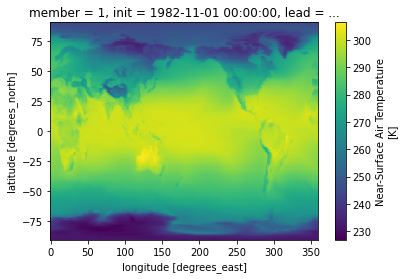

In [44]:
test["tas"].isel(member=0, init=1, lead=0).plot()

### Process some data

In [4]:
PROJECT_DIR = Path("/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/")

config_dir = PROJECT_DIR / "data/config"
save_dir = PROJECT_DIR / "data/processed"

In [5]:
%%time
prepare_dataset(config_dir / "EN422.yml", save_dir)

CPU times: user 3min 5s, sys: 35.3 s, total: 3min 41s
Wall time: 2min 28s


## Check the data

In [296]:
ds = "CAFEf6"
var = "ohc300"
test = xr.open_zarr(PROJECT_DIR / f"data/processed/{ds}.{var}.zarr")
test

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144, member: 40, time: 55)
Coordinates:
    area     (lat, lon) float64 dask.array<chunksize=(90, 144), meta=np.ndarray>
    height   float64 ...
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
  * time     (time) object 1960-12-01 00:00:00 ... 2014-12-01 00:00:00
Data variables:
    t_ref    (member, time, lat, lon) float32 dask.array<chunksize=(40, 55, 90, 144), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

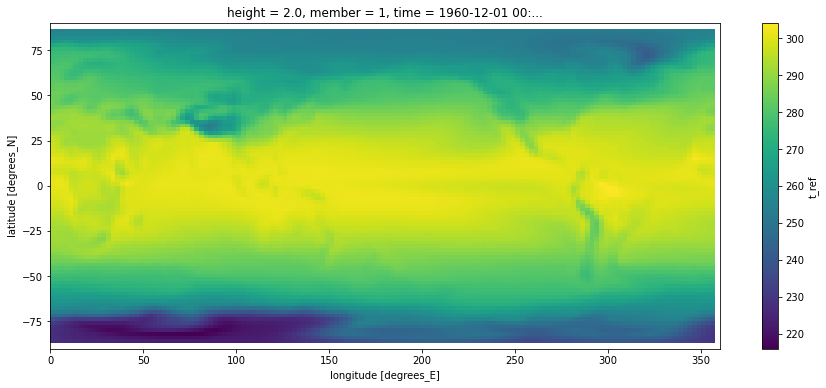

In [297]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 6))
test[var].isel(time=0, member=0).plot()